In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from numpy import array
from Bio import SeqIO
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

# Question 1


Import the data from each dataset with the function *Import_data* :
it takes the input file with all the sequences and it returns two arrays, *proteins* with all the sequences as strings and *functionality*, which is an array of all fucntionalities.

In [90]:
def Import_data(input_file):
    proteins = []
    functionality = []
    for seq_record in SeqIO.parse(input_file, "fasta"):
        proteins.append(str(seq_record.seq))
        if seq_record.description[-2] == 'u':
            functionality.append('T')
        else:
            functionality.append('F')
    return proteins, functionality

proteins_nat_a, functionality_nat = Import_data("MSA_nat_with_annotation.faa")
functionality_nat1 = functionality_nat.copy()
proteins_art, functionality_art = Import_data("MSA_art.faa")
functionality_art1 = functionality_art.copy()  
proteins_nat_no = Import_data("MSA_nat_no_annotation.faa")[0]

*OneHOT* performs the one-hot encoding using some libraries from scikit-learn.

In [91]:
#ONE HOT ENCODING

def OneHOT(data):
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(data)
    onehot_encoder = OneHotEncoder(drop="first",sparse=False,categories='auto')
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    return onehot_encoded

*encode_datasets* takes the array of strings and returns and array with one-hot encoded sequences; 

*split_true_false* splits true and false sequences in two separate arrays


In [92]:
#One-hot encoded version of the datasets

def encode_datasets(proteins,N):
    final_array = np.zeros((N,1920))
    j = 0
    long=''.join(proteins)
    data = [char for char in long]
    data= ['-' if x=='X' else x for x in data]
    onehot_ = OneHOT(data)
    for i in range(0,len(onehot_),96):
        final_array[j,:] = onehot_[i:i+96].reshape(-1)
        j+=1
    return final_array

nat_a = encode_datasets(proteins_nat_a,1130)
art = encode_datasets(proteins_art,1003)
nat_no = encode_datasets(proteins_nat_no,6311)

def split_true_false(data,functionality):
    data_true = []
    data_false = []
    vec_true_false = []
    for i in range(len(data)):
        if functionality[i] == 'T':
            data_true.append(data[i])
            vec_true_false.append(1)
        else:
            data_false.append(data[i])
            vec_true_false.append(0)
    return data_true, data_false, vec_true_false

nat_a_true, nat_a_false, nat_true_false = split_true_false(nat_a,functionality_nat1)
art_true, art_false, art_true_false = split_true_false(art,functionality_art1)


# Question 2


PCA is done by fitting the natural labelled data and projecting all the datasets on PCs given by natural data's fit.

In [93]:
# Importing PCA
from sklearn.decomposition import PCA       
pca = PCA(n_components = 2)
pca.fit(nat_a)
x_pca = pca.transform(nat_a)
y_pca = pca.transform(art)
z_pca = pca.transform(nat_no)
x_pca2 = pca.transform(nat_a_true)
x_pca3 = pca.transform(nat_a_false)
y_pca2 = pca.transform(art_true)
y_pca3 = pca.transform(art_false)

In [94]:
exp_var_ratio = pca.explained_variance_ratio_
exp_var_ratio = exp_var_ratio * 100
exp_var_ratio

array([4.33746148, 3.30132937])

*dataframe* creates a dataframe with the two PCs and the functionality of each sequence

In [65]:
def dataframe(datas,functionality):
    df1 = pd.DataFrame(data = datas, columns = ['principal component 1', 'principal component 2'])
    df2 = pd.DataFrame(data = functionality, columns = ['functionality'])
    return pd.concat([df1,df2], axis = 1)

finalDf_nat_a = dataframe(x_pca,functionality_nat1)
finalDf_art = dataframe(y_pca,functionality_art1)
finalDf_nat_no = pd.DataFrame(data = z_pca, columns = ['principal component 1', 'principal component 2'])

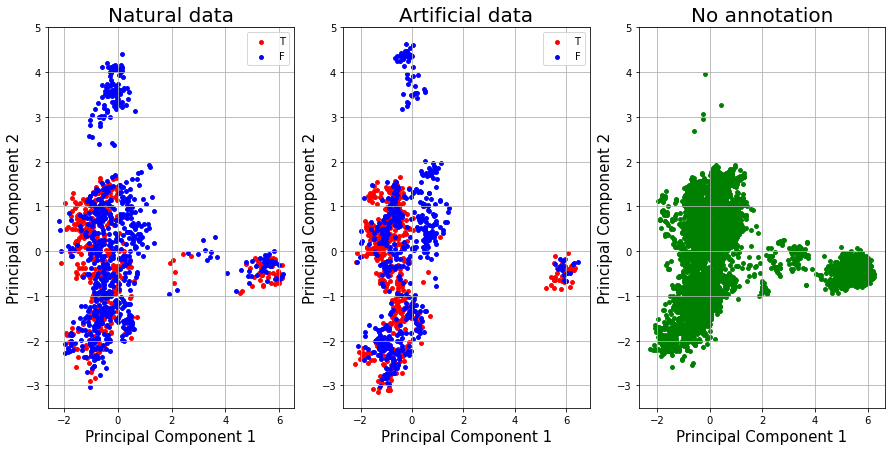

In [66]:
#plots
def plots(ax,dataframe,functionality,title):
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_title(title, fontsize = 20)
    ax.set_ylim(-3.5,5)
    functionalities = ['T', 'F']
    colors = ['r', 'b']
    for functionality, color in zip(functionalities,colors):
        indicesToKeep = dataframe['functionality'] == functionality
        ax.scatter(dataframe.loc[indicesToKeep, 'principal component 1']
                   , dataframe.loc[indicesToKeep, 'principal component 2']
                   , c = color
                   , s = 15)
    ax.legend(functionalities)
    ax.grid()


fig, (ax, ax1, ax2) = plt.subplots(1,3,figsize=(15,7))
ax.set_title('Natural data', fontsize = 20)
plots(ax,finalDf_nat_a,functionality_nat,'Natural data')
ax1.set_title('Artificial data', fontsize = 20)
plots(ax1,finalDf_art,functionality_art,'Artificial data')
ax2.set_xlabel('Principal Component 1', fontsize = 15)
ax2.set_ylabel('Principal Component 2', fontsize = 15)
ax2.set_title('No annotation', fontsize = 20)
ax2.set_ylim(-3.5,5)
ax2.scatter(finalDf_nat_no['principal component 1'], finalDf_nat_no['principal component 2'], s = 15, c='g')
ax2.grid()

plt.savefig('PCA.png',transparent=True)

In these plots the dataset are represented showing their projection on the two PCs. We can notice that labelled data behave similarly, with three clusters: the first one around (0,0), the second one around (0,4) and the third one around (6,0).

In the artificial data we can notice the lack of data between the first and the third cluster: reasons could be investigated in the creation of the artificial data by the generative statistical model.

Functional and non functional data are mostly superimposed in both the labelled datasets: the only separation of the two funcionalities is present in the upper cluster, where only non functional data are present. Then, we tried to visualize the data with three PCs instead of two: this confirms the mixing of data with different functionalities in the central and right clusters.

The unlabelled data are distributed similarly to the labelled data. As expected, some data are present in the region between the two lower clusters as in the first plot, since they both belong to natural proteins. Another important remark is the quasi total absence of data in the upper cluster: we could predict that the few data in this cluster will be non functional.

In [97]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
import plotly.graph_objects as go
pca = PCA(n_components = 3)
data_embedded = pca.fit_transform(nat_a)
label_encoder = LabelEncoder()
color = label_encoder.fit_transform(functionality_nat)

fig = go.Figure(data=[go.Scatter3d(
    x=data_embedded[:,0],
    y=data_embedded[:,1],
    z=data_embedded[:,2],
    mode='markers',
    marker=dict(
        size=3,
        color = color,
        colorscale = 'Viridis',
        opacity = 0.7
    )
)])

fig.update_layout(scene = dict(
                    xaxis_title='First principal component',
                    yaxis_title='Second principal component',
                    zaxis_title='Third principal component'),
                    margin=dict(r=10, b=10, l=10, t=10))
fig.show()

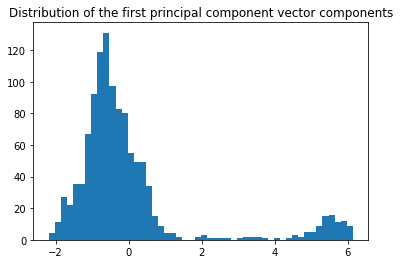

In [96]:
plt.hist(finalDf_nat_a['principal component 1'],bins=50)
plt.title('Distribution of the first principal component vector components')
plt.show()

# Question 3

In order to understand which type of clustering is suitable for our data, we compute the score of success in dividing the functionality well for each method.
The best one is the Agglomerative Clustering, but the score is still very low: this is because the functionalities are not well divided in clusters. 
We did an analysis of the separation of the functionality by calculating the score, i.e. a comparison between the two clusters and the T - F groups: the higher the score, the higher the correspondence of the clusters.

In [69]:
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering
ag = AgglomerativeClustering(n_clusters = 2).fit(nat_a)
ag.labels_
score = 0
for i in range(len(nat_true_false)):
    if nat_true_false[i] == ag.labels_[i]:
        score += 1

print("Agglomerative Clustering score: " +str(score / len(nat_true_false)))

Agglomerative Clustering score: 0.6256637168141593


In [70]:
km = KMeans(n_clusters = 2).fit(nat_a)
km.labels_
score = 0
for i in range(len(nat_true_false)):
    if nat_true_false[i] == km.labels_[i]:
        score += 1

print("KMeans Clustering score: " +str(score / len(nat_true_false)))

KMeans Clustering score: 0.4654867256637168


# KMeans

We use the KMeans clustering to see if the functional sequences are well separated from the non functional ones. We notice that the center of the clusters are very close, therefore there is not a visible separation between functionalities. The only exception is the upper cluster, where there are just non functional sequences, confirming the observations done on PCA analysis.

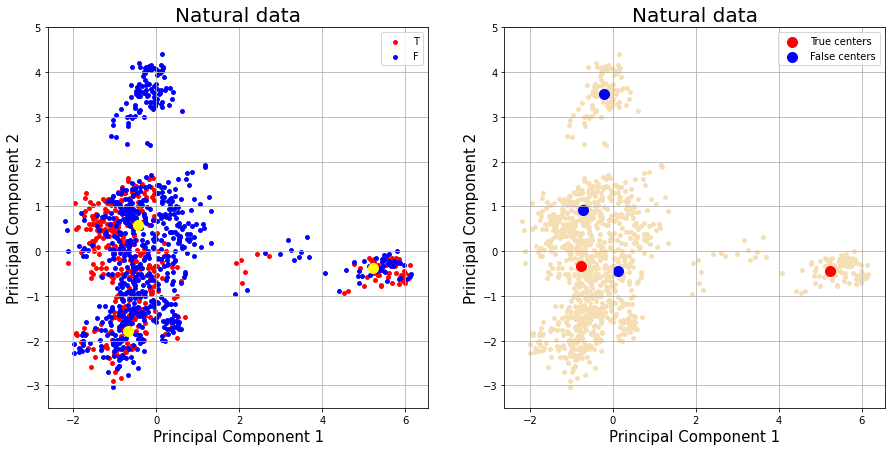

In [71]:
import matplotlib.colors as mcolors
model = KMeans(n_clusters = 3)
model.fit_predict(nat_a)
centers = pca.transform(model.cluster_centers_)

model1 = KMeans(n_clusters = 2)
model1.fit_predict(nat_a_true)
centers1 = pca.transform(model1.cluster_centers_)

model2 = KMeans(n_clusters = 3)
model2.fit_predict(nat_a_false)
centers2 = pca.transform(model2.cluster_centers_)


fig, (ax, ax1) = plt.subplots(1,2,figsize=(15,7))
ax.set_title('Natural data', fontsize = 20)
plots(ax,finalDf_nat_a,functionality_nat,'Natural data')
ax.scatter(centers[:,0],centers[:,1],c='yellow',s=100)
ax.set_ylim(-3.5,5)

ax1.set_title('Natural data', fontsize = 20)
ax1.scatter(x_pca[:,0], x_pca[:,1], c = 'wheat', s = 15)
ax1.scatter(centers1[:,0],centers1[:,1],c='r',s=100,label = 'True centers')
ax1.scatter(centers2[:,0],centers2[:,1],c='b',s=100, label = 'False centers')
ax1.set_xlabel('Principal Component 1', fontsize = 15)
ax1.set_ylabel('Principal Component 2', fontsize = 15)
ax1.set_ylim(-3.5,5)
ax1.legend()
ax1.grid()
plt.savefig('KMeans_nat.png',transparent=True)

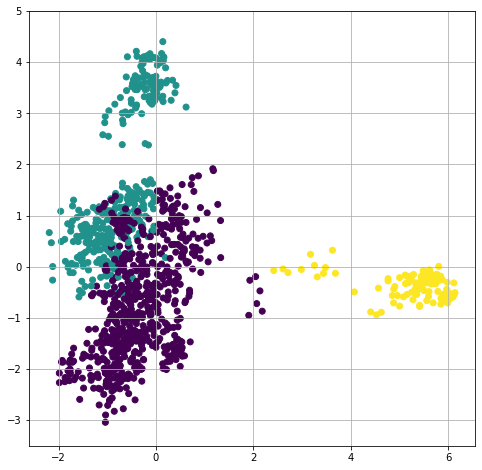

In [72]:
import matplotlib.colors as mcolors
model = KMeans(n_clusters = 3)
model.fit_predict(nat_a)
centers = pca.transform(model.cluster_centers_)

fig, (ax) = plt.subplots(figsize=(8,8))
ax.scatter(x_pca[:,0], x_pca[:,1], c=model.labels_)
ax.set_ylim(-3.5,5)
ax.grid()
plt.savefig('kmeans.png')

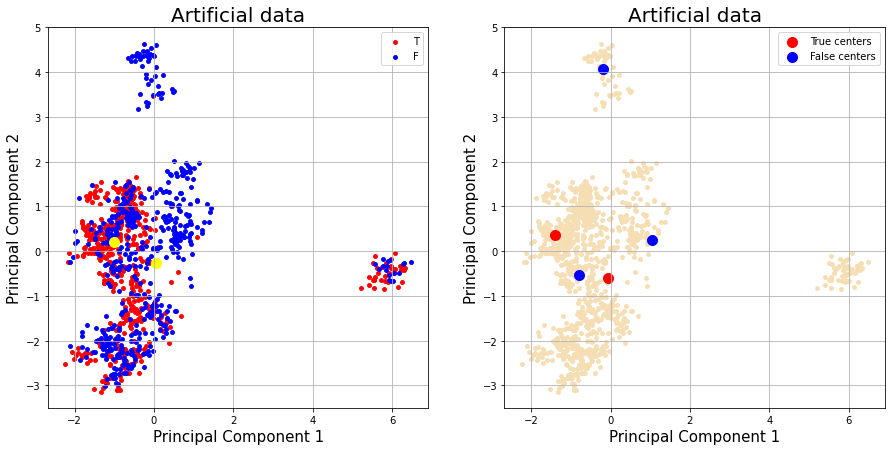

In [73]:
model = KMeans(n_clusters = 2)
model.fit_predict(art)
centers = pca.transform(model.cluster_centers_)

model1 = KMeans(n_clusters = 2)
model1.fit_predict(art_true)
centers1 = pca.transform(model1.cluster_centers_)

model2 = KMeans(n_clusters = 3)
model2.fit_predict(art_false)
centers2 = pca.transform(model2.cluster_centers_)


fig, (ax, ax1) = plt.subplots(1,2,figsize=(15,7))
ax.set_title('Artificial data', fontsize = 20)
plots(ax,finalDf_art,functionality_art,'Artificial data')
ax.scatter(centers[:,0],centers[:,1],c='yellow',s=100)
ax.set_ylim(-3.5,5)

ax1.set_title('Artificial data', fontsize = 20)
ax1.scatter(y_pca[:,0], y_pca[:,1], c = 'wheat', s = 15)
ax1.scatter(centers1[:,0],centers1[:,1],c='r',s=100,label = 'True centers')
ax1.scatter(centers2[:,0],centers2[:,1],c='b',s=100, label = 'False centers')
ax1.set_xlabel('Principal Component 1', fontsize = 15)
ax1.set_ylabel('Principal Component 2', fontsize = 15)
ax1.set_ylim(-3.5,5)
ax1.legend()
ax1.grid()
plt.savefig('KMeans_art.png',transparent=True)

# Agglomerative Clustering

We use the Agglomerative Clustering to see if there are some distinctions in clusters for the different datasets. Only the natural labelled data are distinguishable in three clusters, as we noticed in the PCA analysis. The other two datasets have clusters that seems superimposed: this is due to the fact that we are visualizing the data in two dimensions but the clustering is done on the non-dimensionally reducted data (i.e. before PCA).

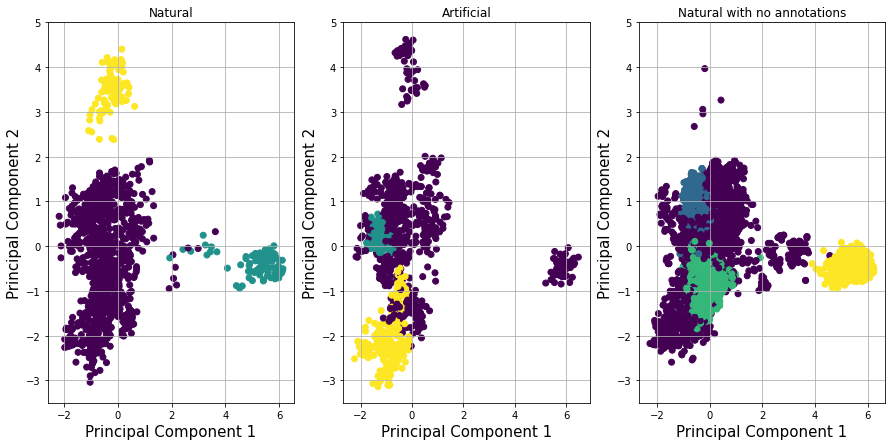

In [74]:
from sklearn.cluster import AgglomerativeClustering
fig, (ax, ax1,ax2) = plt.subplots(1,3,figsize=(15,7))

n = 3

cluster = AgglomerativeClustering(n_clusters=3)
cluster.fit_predict(nat_a)
ax.scatter(x_pca[:,0], x_pca[:,1], c=cluster.labels_)
ax.set_ylim(-3.5,5)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('Natural')
ax.grid()

cluster1 = AgglomerativeClustering(n_clusters=3)
cluster1.fit_predict(art)
ax1.scatter(y_pca[:,0], y_pca[:,1], c=cluster1.labels_)
ax1.set_ylim(-3.5,5)
ax1.set_xlabel('Principal Component 1', fontsize = 15)
ax1.set_ylabel('Principal Component 2', fontsize = 15)
ax1.set_title('Artificial')
ax1.grid()

cluster2 = AgglomerativeClustering(n_clusters=4)
cluster2.fit_predict(nat_no)
ax2.scatter(z_pca[:,0], z_pca[:,1], c=cluster2.labels_)
ax2.set_ylim(-3.5,5)
ax2.set_xlabel('Principal Component 1', fontsize = 15)
ax2.set_ylabel('Principal Component 2', fontsize = 15)
ax2.set_title('Natural with no annotations')
ax2.grid()

plt.savefig('Agglomerative.png',transparent=True)

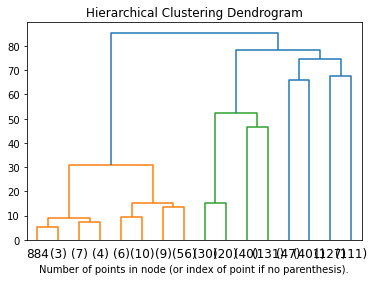

In [75]:
from scipy.cluster.hierarchy import dendrogram


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

cluster = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
cluster = cluster.fit(art)


plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(cluster, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.savefig('Dendrogram.png',transparent=True)

## Question 4

While deciding which type of supervised learning was suitable to our data, we reduced our choices to the logistic regression and the random forest. The supervised learning is useful to predict a label for the unlabelled data, by training the model on the already labelled datasets.

X is the union of all the labelled sequences, y is the union of all the labels assigned to these sequences.
The training set is 70% of the total, chosen at random by the function *train_test_split*.

We can find two quantitative measures to understand if the model is working or not:
the *score* gives how well the model predicts the labels of the training set, while the *accuracy* gives how well the model predicts the labels of the test set.

The score is useful just to check if there are not bug in the program (it's ok if it's very close to one, as in our case), while the accuracy gives the power of prediction of our model on new data, out of the training set.
We compare the accuracies of the two models here

In [76]:
def learning(model):
    X = np.concatenate([nat_a, art])
    y = np.concatenate([nat_true_false,art_true_false])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = model.score(X_train,y_train)
    acc = accuracy_score(y_test, y_pred)
    return score,acc

In [77]:
lr = LogisticRegression(solver='liblinear')
rf = RandomForestClassifier(n_estimators = 100, random_state = 0)

score,acc = learning(lr)
print('LOGISTIC REGRESSION')
print('Score: ' +str(score))
print('Accuracy: ' +str(acc))

score,acc = learning(rf)
print('RANDOM FOREST')
print('Score: ' +str(score))
print('Accuracy: ' +str(acc))

LOGISTIC REGRESSION
Score: 0.9899531145344943
Accuracy: 0.75625
RANDOM FOREST
Score: 1.0
Accuracy: 0.7859375


The two models have a similar accuracy, therefore we can use them both and obtain similar, satisfying results.

## Logistic regression

In [78]:
X = np.concatenate([nat_a, art])
y = np.concatenate([nat_true_false,art_true_false])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
model = LogisticRegression(solver='liblinear')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

Here we show the confusion matrix: it represents graphically how many labels of the test set are well or bad predicted by the model.

              precision    recall  f1-score   support

           0       0.79      0.81      0.80       362
           1       0.74      0.72      0.73       278

    accuracy                           0.77       640
   macro avg       0.76      0.76      0.76       640
weighted avg       0.77      0.77      0.77       640



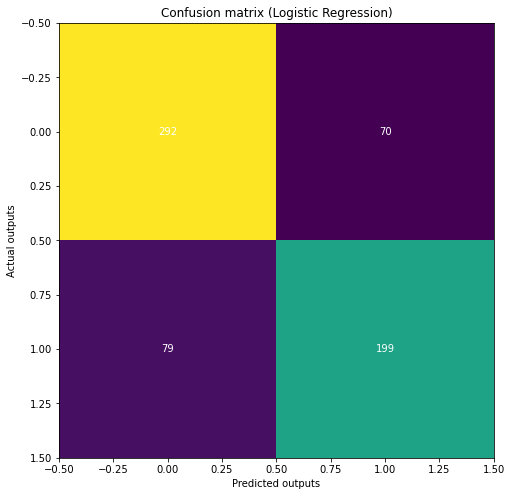

In [79]:
cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.set_xlabel('Predicted outputs', fontsize=10, color='black')
ax.set_ylabel('Actual outputs', fontsize=10, color='black')
ax.set_title('Confusion matrix (Logistic Regression)')
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='white')
plt.savefig('confusion_matrix_LR.png')
print(classification_report(y_test, y_pred))

Here we predict the labels for the unlabelled dataset.

In [80]:
x_nolabel = nat_no
y_pred_nolabel = model.predict(x_nolabel)

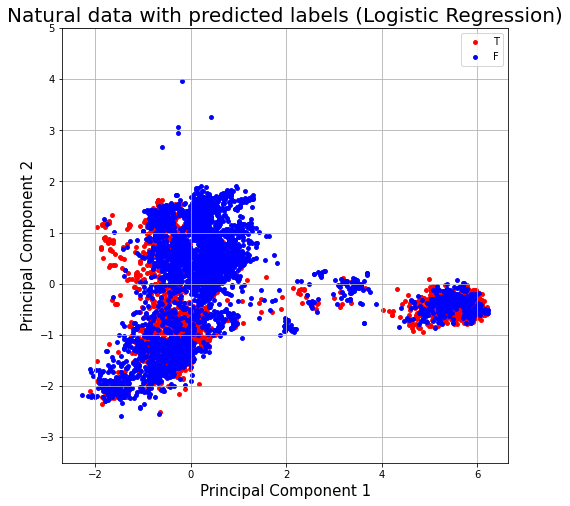

In [81]:
def plots(ax,dataframe,functionality):
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_title('Natural data with predicted labels (Logistic Regression)', fontsize = 20)
    functionalities = [1,0]
    funct = ['T','F']
    colors = ['r', 'b']
    for functionality, color in zip(functionalities,colors):
        indicesToKeep = dataframe['functionality'] == functionality
        ax.scatter(dataframe.loc[indicesToKeep, 'principal component 1']
                   , dataframe.loc[indicesToKeep, 'principal component 2']
                   , c = color
                   , s = 15)
    ax.legend(funct)
    ax.grid()
fig, ax = plt.subplots(figsize=(8, 8))
df = dataframe(z_pca,y_pred_nolabel)
ax.set_ylim(-3.5,5)
plots(ax,df,y_pred_nolabel)
plt.savefig('unlabelled_LR.png')

## Random forest

In [82]:
X = np.concatenate([nat_a, art])
y = np.concatenate([nat_true_false,art_true_false])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)


model = RandomForestClassifier(n_estimators = 100, random_state = 0)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

              precision    recall  f1-score   support

           0       0.79      0.86      0.82       355
           1       0.80      0.71      0.75       285

    accuracy                           0.79       640
   macro avg       0.79      0.78      0.79       640
weighted avg       0.79      0.79      0.79       640



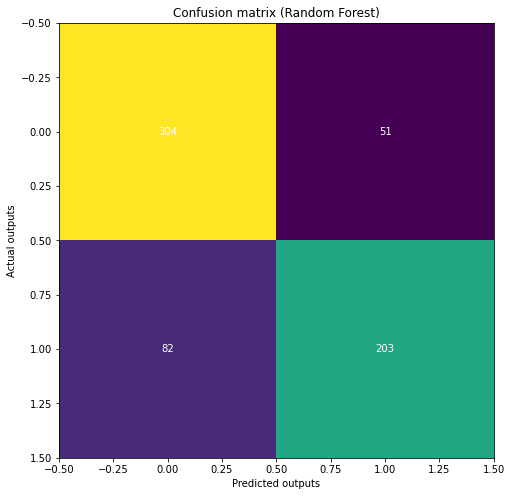

In [83]:
cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.set_xlabel('Predicted outputs', fontsize=10, color='black')
ax.set_ylabel('Actual outputs', fontsize=10, color='black')
ax.set_title('Confusion matrix (Random Forest)')
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='white')
plt.savefig('confusion_matrix_RF.png')
print(classification_report(y_test, y_pred))

In [84]:
x_nolabel = nat_no
y_pred_nolabel = model.predict(x_nolabel)

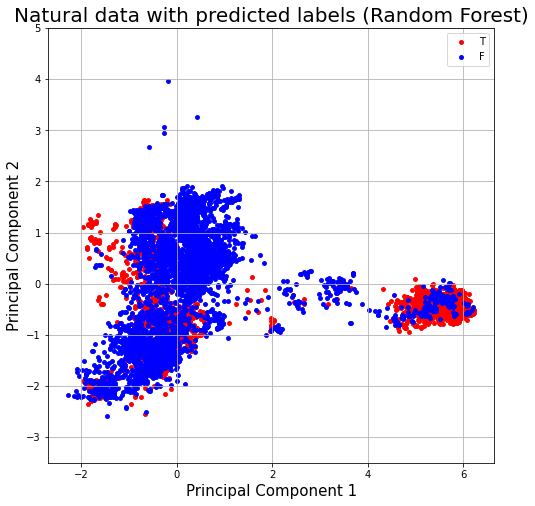

In [85]:
def plots(ax,dataframe,functionality):
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_title('Natural data with predicted labels (Random Forest)', fontsize = 20)
    functionalities = [1,0]
    funct = ['T','F']
    colors = ['r', 'b']
    for functionality, color in zip(functionalities,colors):
        indicesToKeep = dataframe['functionality'] == functionality
        ax.scatter(dataframe.loc[indicesToKeep, 'principal component 1']
                   , dataframe.loc[indicesToKeep, 'principal component 2']
                   , c = color
                   , s = 15)
    ax.legend(funct)
    ax.grid()
fig, ax = plt.subplots(figsize=(8, 8))
df = dataframe(z_pca,y_pred_nolabel)
ax.set_ylim(-3.5,5)
plots(ax,df,y_pred_nolabel)
plt.savefig('unlabelled_RF.png')

After the supervised learning, (initially) unlabelled data are very similar to the labelled sets; in the lower clusters te functional and non functional sequences are superimposed, while for PC2 > 2 just non functional sequences are present.